<a href="https://colab.research.google.com/github/axiom9/WebScraping_and_NLP/blob/main/NLP_Disaster_Tweet_Classification_LSTM_%26_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/deep-learning-pipeline-for-natural-language-processing-nlp-c6f4074897bb

https://tfhub.dev/google/nnlm-en-dim50/2

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

https://medium.com/analytics-vidhya/introduction-to-nlp-with-disaster-tweets-3b672a75748c

https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/

Model architecture: https://www.kaggle.com/choureymanas/is-it-a-disaster

# **Pre-reqs (Loading data)**

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Mon Jan 24 01:47:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [7]:
def load_data():
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c nlp-getting-started

In [8]:
load_data()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


# **Pre-processing Data**

### Imports

In [9]:
! pip install langdetect
! pip install nltk==3.4
import nltk
# nltk.download('words')
nltk.download('punkt')
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd

from langdetect import detect

import re

import string
from string import digits

nltk.__version__

     |████████████████████████████████| 981 kB 8.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=c2ed777cf6ad61933a860c046d1aa04ca4335fe39056107ed1236f1e6a7e73a5
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 1.4 MB 8.2 MB/s 
  Created wheel for nltk: filename=nltk-3.4-py3-none-any.whl size=1436399 sha256=c500bd89be29918054f61b2f793b0d21916af3c267448d88098171504cf03607
  Stored in directory: /root/.cache/pip/wheels/13/b8/81/2349be11dd144dc7b68ab983b58cd2fae353cdc50bbdeb09d0
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'3.4'

In [10]:
df = pd.read_csv('/content/train.csv')

In [11]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [12]:
df.isna().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

## Now we can begin pre-processing the sentences:

* Drop duplicates if any
* Drop any columns that might not be needed
* Drop missing values if any
* Remove punctuations
* Convert the words into lowercase
* Remove URLs, the word “twitter” and other acronyms
* Extract only tweets that are in English
* Tokenize (break the tweets into single words)
* Remove stopwords


In [13]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [14]:
# df2copy = df.text
# df2copy.apply(lambda sentences: [sentence for x in sentences if x in words.words()])

In [15]:

try:
    words = set(nltk.corpus.words.words())
except LookupError:
  nltk.download('words')
finally:
  words = set(nltk.corpus.words.words())

try:
  stop_words = set(stopwords.words('english'))
except LookupError:
  nltk.download('stopwords')
finally:
  stop_words = set(stopwords.words('english'))

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [16]:
def clean_data(df):
    """Function that cleans the data by dropping unwanted columns, duplicates, rows w/ missing tweets. Additionally, 
    it removes punctuation, expands contractions, removes stop-words, and performs lemmatization
    using NLTK Wordnet Lemmatizer."""

    # Dictionary to expand contractions (will be used later)
    contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not", 
                     "shouldn't":"should not", "wouldn't":"would not", "couldn't":"could not",
                     "they're": "they are", "he'd":"he would", "I'm": "I am", "he's":"he is",
                     "isn't": "is not"}

    #Function to remove digits in text                    
    def remove_nums(text):
        """Removes any text (word) containing digits in it and properly concatenates
        the remaining sentence"""
        return " ".join(re.sub(r'\w*\d\w*', '', text).strip().split())

    #Function to remove URLs
    def remove_URL(text):
        """Remove URLs from a text string"""
        return re.sub(r"http\S+", "", text)

    # Function to expand contractions based on the contractions_dict
    def expand_contractions(text,contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)

    # Function to remove ascii characters
    def remove_ascii(text):
        """Removes any ascii characters"""
        return text.encode("ascii", "ignore").decode()

    # Function to remove stop words
    def remove_stopwords(text):
        """Removes stopwords from a corpus"""
        return " ".join([word for word in str(text).split() if word not in stop_words])

    # Function to lemmatize words
    def lemmatize_words(text):
        """ Uses NLTK wordnet lemmatizer to lemmatize words """
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


    # def detect_languages(df):
    #     """Function that adds a new column in the dataframe passed that is the language the text is in"""
    #     # Check if the language is en, if it is do nothing, if it isn't then drop it
    #     for i in range(len(df.text)):
    #         if detect(df.text[i]) == 'en':
    #             df.drop(i, inplace=True)

    #Detect and drop rows that aren't in English - Temporarily excluding
    # detect_languages(df)

    # Make a copy of the df
    df = df.copy()

    # Drop columns that aren't needed
    cols_to_drop = ['id', 'keyword', 'location']
    df = df.drop(cols_to_drop, axis=1)
    # Note: We only need 'text' and 'target' columns for this deep learning task. Other columns can be effectively discarded

    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    # Expanding Contractions in the reviews
    df.text=df.text.apply(lambda x:expand_contractions(x))

    # Remove URLs
    df.text = df.text.apply(lambda x: remove_URL(x))

    # Remove ascii characters / text
    df.text = df.text.apply(lambda x:remove_ascii(x))

    # Removing punctutations
    df.text = df.text.apply(lambda x: x.translate(str.maketrans(' ',' ', string.punctuation)))

    # Removing numbers
    # df.text = df.text.apply(lambda x: x.translate(str.maketrans(' ',' ', digits)))
    df.text = df.text.apply(lambda x: remove_nums(x))

    # Lowercase
    df.text = df.text.apply(lambda x: x.lower())

    # Drop duplicates
    df.drop_duplicates(inplace=True) 

    # Drop any rows with missing tweets
    df.text.dropna(inplace=True)

    # Remove stop-words
    df.text = df.text.apply(lambda x: remove_stopwords(x))

    # Get the lemma of the words
    df.text = df.text.apply(lambda x: lemmatize_words(x))

    # Function to remove any extra unwanted spaces
    df.text = df.text.apply(lambda x: re.sub(' +', ' ', x))

    # Output the cleaned up dataframe
    return df

def tokenize_data(df):
    """ Performs tokenization on the sentences in the data """
    
    # Finally, let's perform tokenization using NLTK's module 'word_tokenize'
    df.text = df.text.apply(lambda x: nltk.word_tokenize(x))

    return df

In [17]:
df2 = df.copy()
df2 = clean_data(df2)
df2 = tokenize_data(df2)
df2

,text,target
0,"[deed, reason, earthquake, may, allah, forgive...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[resident, asked, ishelter, place, notified, o...",1
3,"[people, receive, wildfire, evacuation, order,...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
...,...,...
7601,"[breaking, la, refugio, oil, spill, may, costl...",1
7602,"[siren, went, wasnt, forney, tornado, warning]",1
7603,"[official, say, quarantine, place, alabama, ho...",1
7605,"[flip, side, walmart, bomb, everyone, evacuate...",1


# **Exploratory Data Analysis**

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import ngrams
from collections import Counter, defaultdict
from itertools import chain

import statistics

# from IPython.core.display import HTML, display

In [19]:
# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


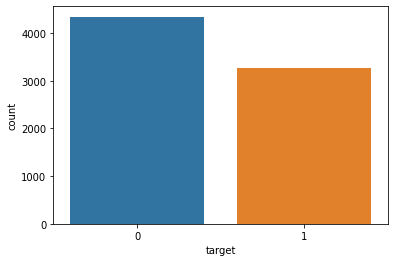

In [20]:
sns.countplot(df.target);


Fairly evenly distributed

In [21]:
def ngram_counts(n, df):
    def gen_ngrams(text, n):
        """ This function generates n-grams for all lists containing text 
        in a dataframe format """

        return [gram for gram in ngrams(text, n)]

    # Copy the df
    df = df.copy()

    # df3['grams'] = df3.text.apply(lambda x: gen_ngrams(x, 2))
    grams = df.text.apply(lambda x: gen_ngrams(x, n)).tolist()

    # Counter(df3.grams[62]).most_common(10)

    # bigrams = df3['grams'].tolist()
    grams = list(chain(*grams))

    gram_counts = Counter(grams)

    return  gram_counts.most_common(12)


In [22]:
# def gen_df_ngrams(df, n):
#     """ This function outputs 'n' number of of dataframes with the inputted filter
#     example: if you want no filter, then input 'df2', if you want the
#     disaster tweets, input 'df_sad' """

# Generate various n-grams for the entire dataset (all tweets)
whole_df_1 = pd.DataFrame(ngram_counts(1, df2), columns=['grams', 'counts']) #<-- whole dataset, unigrams
whole_df_2 = pd.DataFrame(ngram_counts(2, df2), columns=['grams', 'counts']) #<-- whole dataset, bigrams
whole_df_3 = pd.DataFrame(ngram_counts(3, df2), columns=['grams', 'counts']) #<-- whole dataset, trigrams

# Filter the dataframe so it's only either a '1' disaster or a '0'
df_happy = df2[df2.target == 0]
df_sad = df2[df2.target == 1]

# Generate various n-grams for the two filters
dis_1 = pd.DataFrame(ngram_counts(1, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, unigrams
dis_2 = pd.DataFrame(ngram_counts(2, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, bigrams
dis_3 = pd.DataFrame(ngram_counts(3, df_sad), columns=['grams', 'counts']) #<-- disaster tweets, trigrams

ndis_1 = pd.DataFrame(ngram_counts(1, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, unigrams
ndis_2 = pd.DataFrame(ngram_counts(2, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, bigrams
ndis_3 = pd.DataFrame(ngram_counts(3, df_happy), columns=['grams', 'counts']) #<-- non-disaster tweets, trigrams

In [23]:
sns.set_style('darkgrid')
def gen_plot(df):
    plt.figure(figsize=(15,7));
    sns.barplot(x=df.counts, y=df.grams, data=df);
    plt.ylabel('Grams', fontsize=12.0, fontweight='bold')
    plt.xlabel('Counts', fontsize=12.0, fontweight='bold')
    
# fig, axs = plt.subplots(ncols=3, figsize=(10,10))

# sns.barplot(x=dis_1.counts, y=dis_1.grams, ax=axs[0])
# # sns.barplot(x=dis_2.counts, y=dis_2.grams, ax=axs[1])
# # sns.barplot(x=dis_3.counts, y=dis_3.grams, ax=axs[2])

## Plots for n-grams

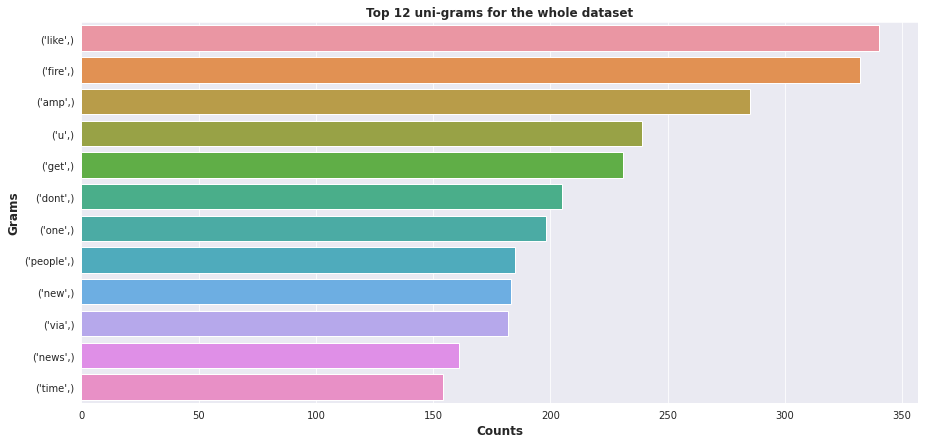

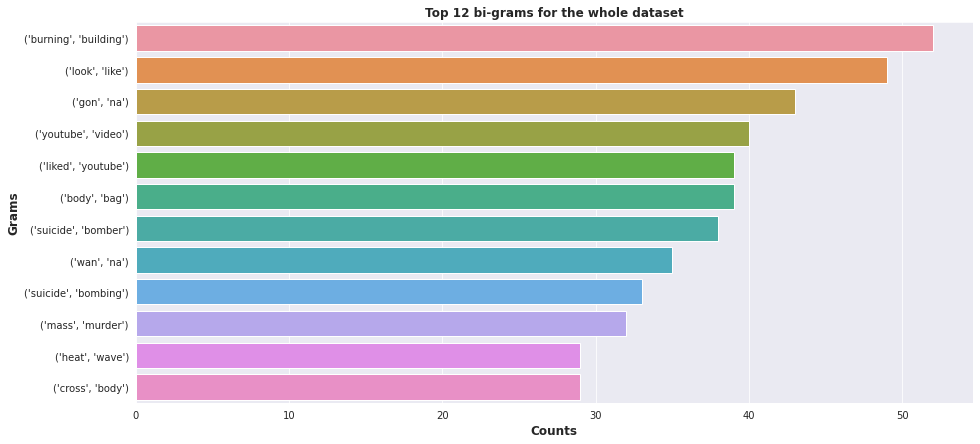

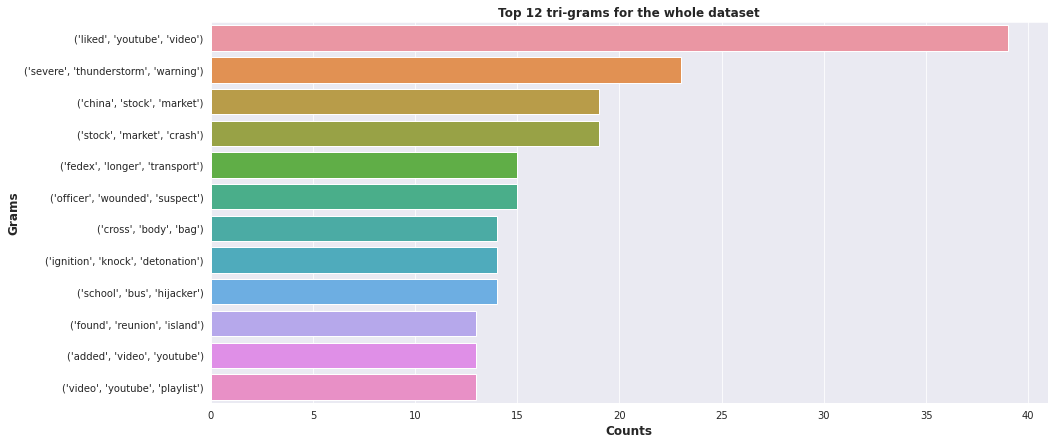

In [24]:
gen_plot(whole_df_1)
plt.title('Top 12 uni-grams for the whole dataset',fontsize=12.0, fontweight='bold');
gen_plot(whole_df_2)
plt.title('Top 12 bi-grams for the whole dataset', fontsize=12.0, fontweight='bold');
gen_plot(whole_df_3)
plt.title('Top 12 tri-grams for the whole dataset', fontsize=12.0, fontweight='bold');

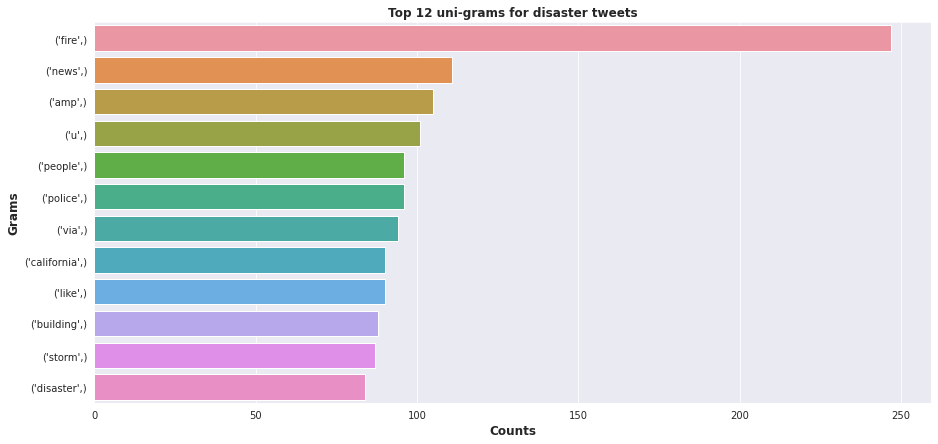

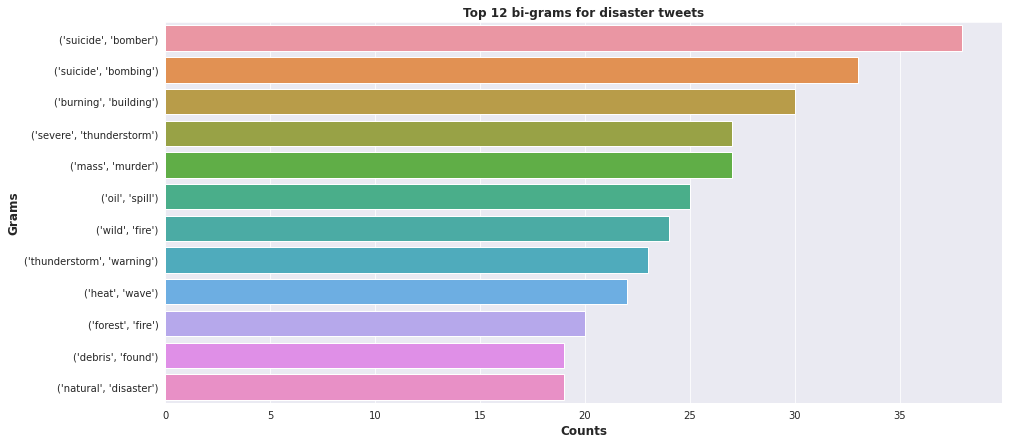

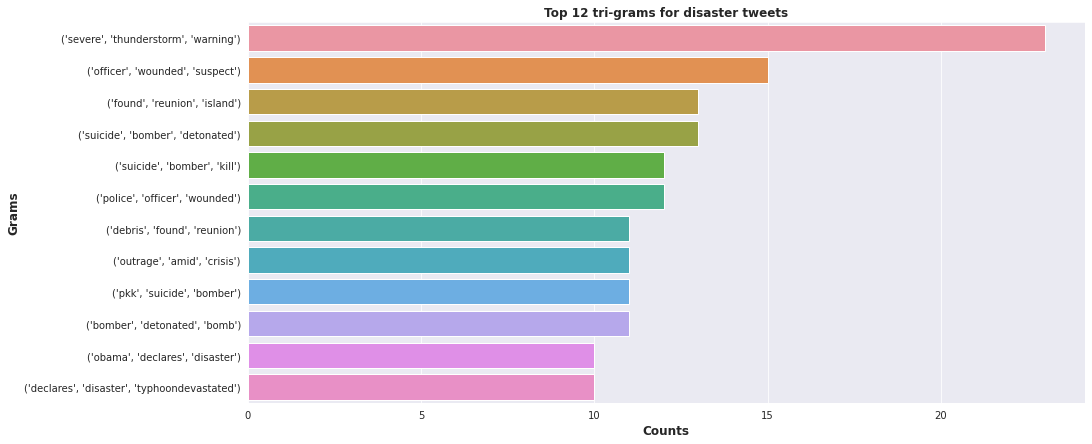

In [25]:
gen_plot(dis_1)
plt.title('Top 12 uni-grams for disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(dis_2)
plt.title('Top 12 bi-grams for disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(dis_3)
plt.title('Top 12 tri-grams for disaster tweets', fontsize=12.0, fontweight='bold');

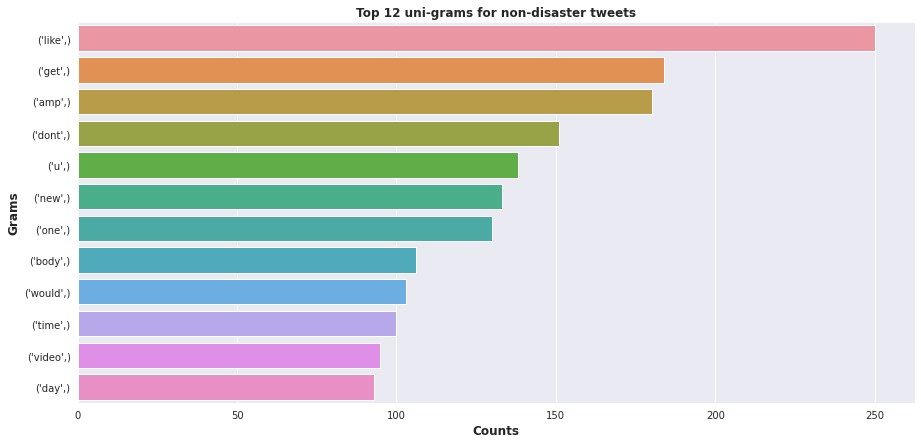

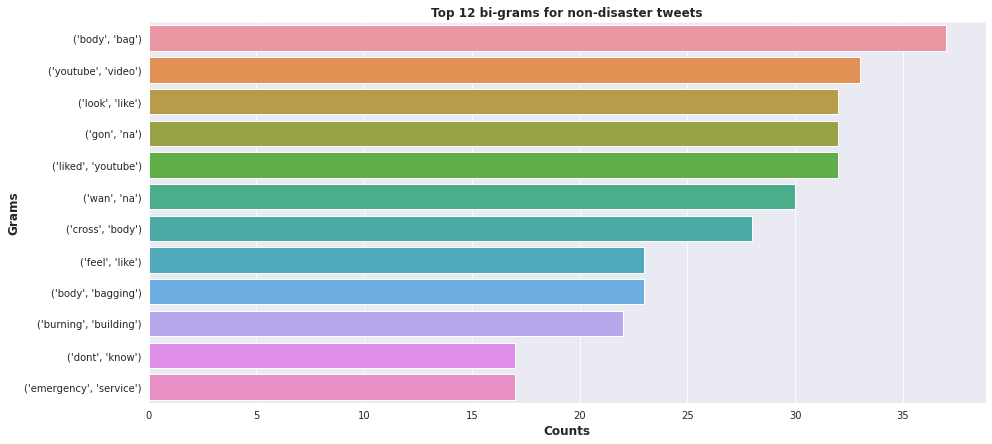

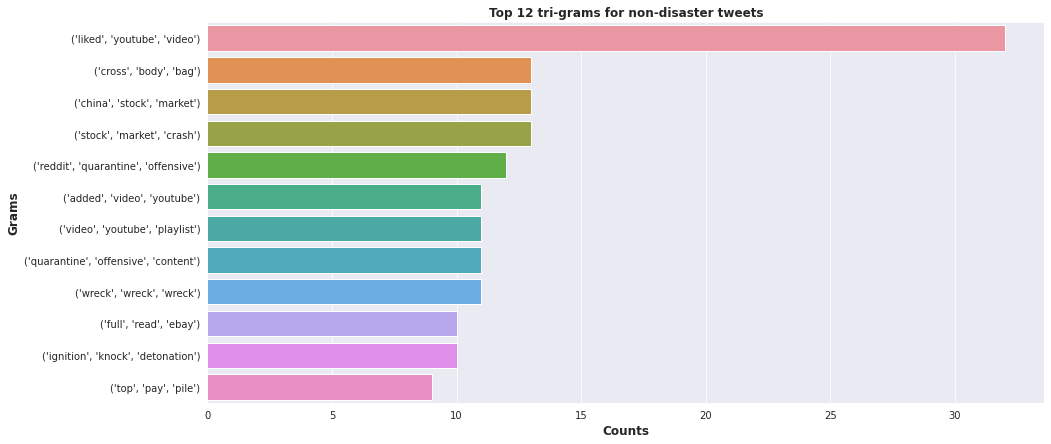

In [26]:
gen_plot(ndis_1)
plt.title('Top 12 uni-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(ndis_2)
plt.title('Top 12 bi-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');
gen_plot(ndis_3)
plt.title('Top 12 tri-grams for non-disaster tweets', fontsize=12.0, fontweight='bold');

In [27]:
# To-do: Visualize 'sentence' lengths for the three divisions (entire dataset, disaster tweets, and non-disaster tweets) then OHE and vectorize and move into model development

## Visualizing the lengths of sentences for the three divisions (i.e. entire dataset, disaster tweets, and non-disaster tweets)

In [28]:
# Want to make a box-plot of the lengths of the sentences from 1. Entire dataset, 2. Disaster tweets and 3. Non-disaster tweets

In [29]:
def gen_boxplot(df):
    """ This function generates a histogram & boxplot of the lengths of each tweet for the given dataframe"""

    def get_lens(text):
        """ This function returns the length of any inputted text """
        return len(text)

    lengths = df.text.apply(lambda x: get_lens(x)).tolist()

    # avg_len = sum(lengths) / len(lengths)
    avg = statistics.mean(lengths)
    mode = statistics.mode(lengths)
    median = statistics.median(lengths)

    print(f'The mean length of tweets is: {avg} --> {round(avg)}\
    \nThe most common length of tweets is: {mode}\
    \nThe median length of tweets is: {median}')

    plt.figure(figsize=(20,10))

    if df is df_happy:
        print(' ')
        plt.subplot(1, 2, 1)
        sns.histplot(data=lengths, bins=10)
        plt.title('Histogram of lengths of non-disaster tweets', fontsize= 12, fontweight='bold')
        plt.ylabel('Counts', fontsize= 12, fontweight='bold')
        plt.xlabel('Lengths of tweets', fontsize= 12, fontweight='bold')

        plt.subplot(1, 2, 2)
        sns.boxplot(data=lengths)
        plt.title('Boxplot of lengths of non-disaster tweets', fontsize= 12, fontweight='bold')
        plt.ylabel('Lengths of tweets', fontsize= 12, fontweight='bold')

    elif df is df_sad:
        print(' ')
        plt.subplot(1, 2, 1)
        sns.histplot(data=lengths, bins=10,color='red')
        plt.title('Histogram of lengths of disaster tweets', fontsize= 12, fontweight='bold')
        plt.ylabel('Counts', fontsize= 12, fontweight='bold')
        plt.xlabel('Lengths of tweets', fontsize= 12, fontweight='bold')

        plt.subplot(1, 2, 2)
        sns.boxplot(data=lengths, color='red')
        plt.title('Boxplot of lengths of disaster tweets', fontsize= 12, fontweight='bold')
        plt.ylabel('Lengths of tweets', fontsize= 12, fontweight='bold')


The mean length of tweets is: 8.547211350293543 --> 9    
The most common length of tweets is: 9    
The median length of tweets is: 9.0
 


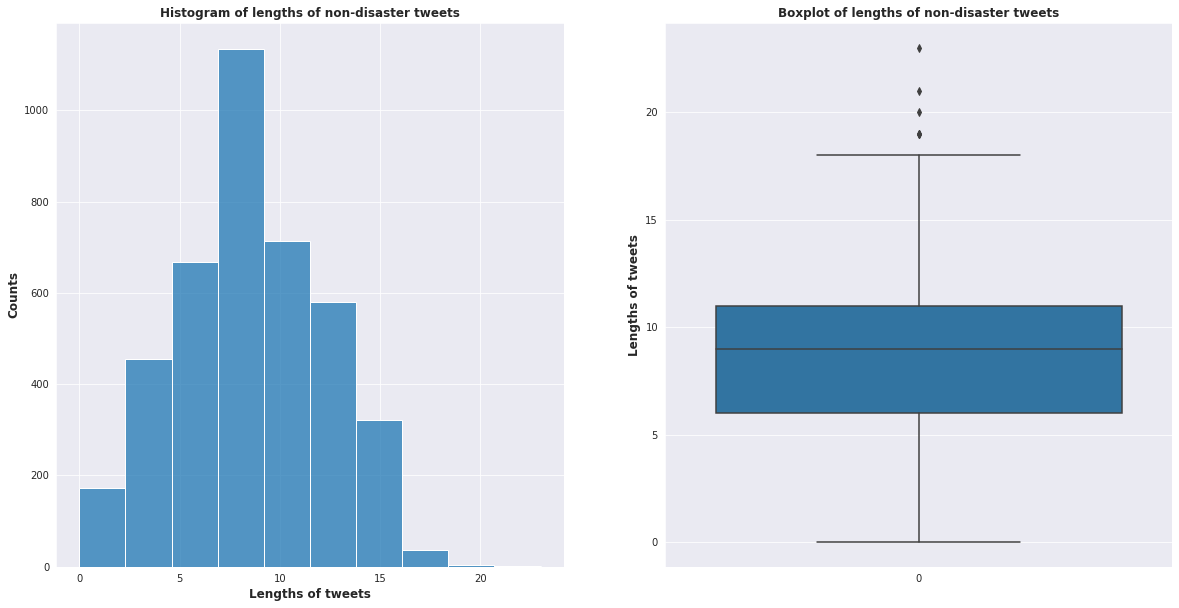

In [30]:
gen_boxplot(df_happy)

The mean length of tweets is: 9.375527426160337 --> 9    
The most common length of tweets is: 9    
The median length of tweets is: 9.0
 


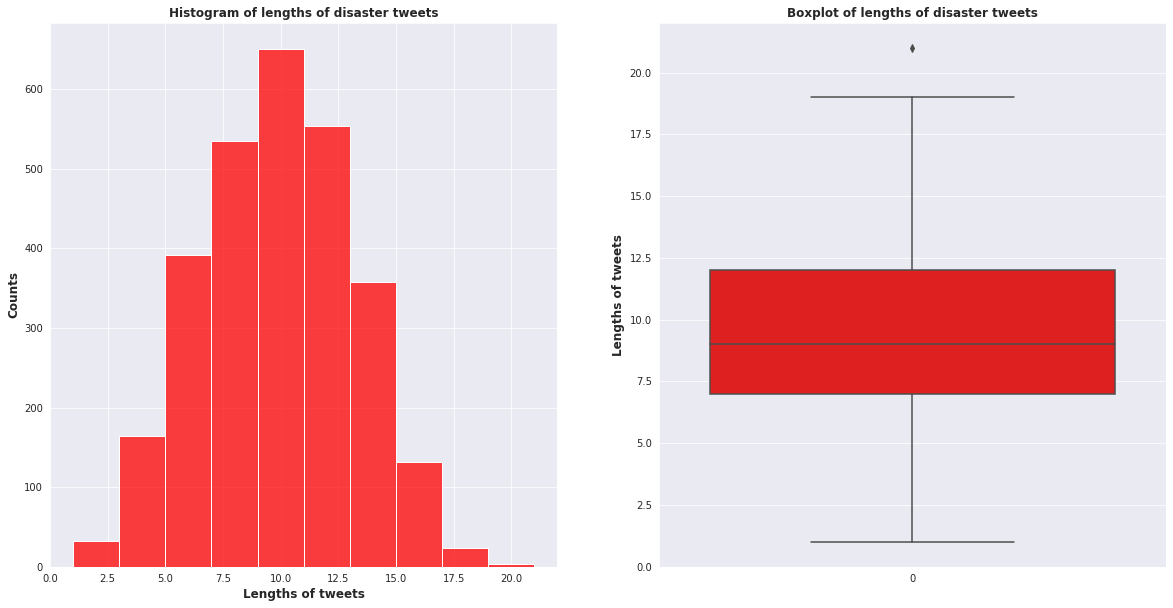

In [31]:
gen_boxplot(df_sad)

In [32]:
def gen_boxplots(df1, df2, df3):
    """ This function generates a histogram & boxplot of the lengths of each tweet for the given dataframe"""

    def get_lens(text):
        """ This function returns the length of any inputted text """
        return len(text)

    lst1 = df1.text.apply(lambda x: get_lens(x)).tolist()
    lst2 = df2.text.apply(lambda x: get_lens(x)).tolist()
    lst3 = df3.text.apply(lambda x: get_lens(x)).tolist()


    my_dict = {'Whole Dataset': lst1, 'Non-Disaster Tweets': lst2, 'Disaster Tweets':lst3};
    fig, ax = plt.subplots(figsize=(12,10));
    ax.boxplot(my_dict.values());
    ax.set_xticklabels(my_dict.keys());
    plt.ylabel('Counts', fontsize=12, fontweight='light')
    # plt.legend(my_dict.keys())

    

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


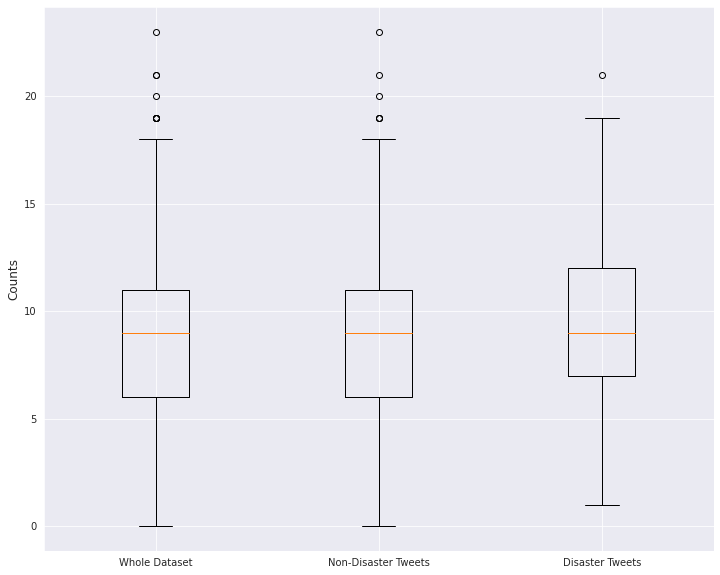

In [33]:
gen_boxplots(df2, df_happy, df_sad)

In [34]:
def gen_histplots(df1, df2, df3):
    """ This function generates a histogram & boxplot of the lengths of each tweet for the given dataframe"""

    def get_lens(text):
        """ This function returns the length of any inputted text """
        return len(text)

    lst1 = df1.text.apply(lambda x: get_lens(x)).tolist()
    lst2 = df2.text.apply(lambda x: get_lens(x)).tolist()
    lst3 = df3.text.apply(lambda x: get_lens(x)).tolist()

    # Repeat process with histplots then begin model development
    plt.figure(figsize=(12,10))
    plt.hist(lst1, bins=10, alpha=.3, label="All Tweets")
    plt.hist(lst2, bins=10, alpha=0.5, label="Non-Disaster Tweets")
    plt.hist(lst3, bins=10, alpha=0.5, label="Disaster Tweets")
    plt.xlabel("Length of Tweets", size=14)
    plt.ylabel("Count", size=14)
    plt.title("Histograms overlayed", fontsize = 14)
    plt.legend(loc='upper right')

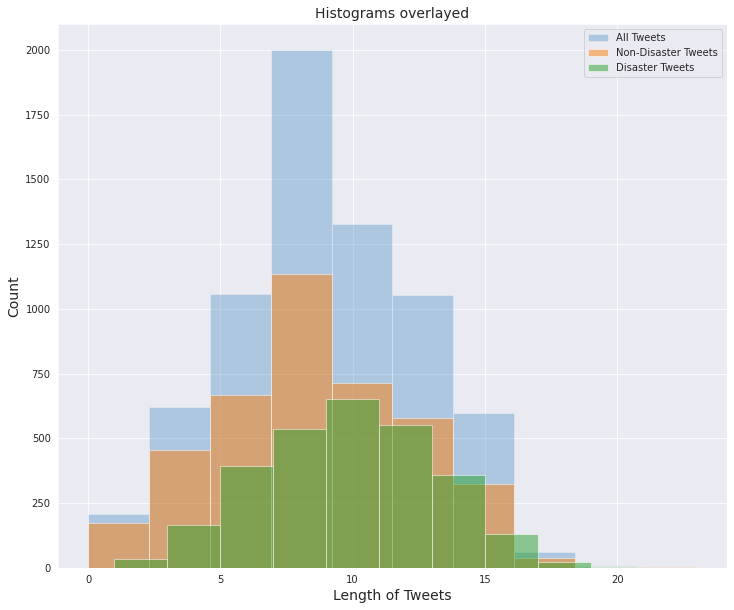

In [35]:
gen_histplots(df2, df_happy, df_sad)

# **Model Development**

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer



import numpy as np

from sklearn.model_selection import train_test_split

tf.__version__

'2.7.0'

In [37]:
df = clean_data(df)

In [38]:
train_corpus = [x for x in df.text]
# def count_words(text):
#     c = Counter()
#     for i in text.values:
#         for word in i.split():
#             c[word] += 1
#     return c

# # train_corpus[0].values

# tc = df2.text
# targ = df2.target
# counter = count_words(tc)
# counter
# num_words = len(counter)
voc_size = 50000
sent_len = 20
onehot_repr =[one_hot(word,voc_size)for word in train_corpus]

embedded_layer = pad_sequences(onehot_repr, maxlen = sent_len)

# Splitting data before fitting

# train_size = int(tc.shape[0] * .80) #80 - 20 split

# train_sents = tc[:train_size]
# train_labels = targ[:train_size]

# val_sents = tc[train_size:]
# val_labels = targ[train_size:]

# tokenizer=Tokenizer(num_words=num_words)
# tokenizer.fit_on_texts(train_sents)

# word_index = tokenizer.word_index

# train_seq = tokenizer.texts_to_sequences(train_sents)

# val_seq = tokenizer.texts_to_sequences(val_sents)

In [39]:
# train_pad = pad_sequences(train_seq, maxlen = sent_len, padding='post', truncating='post')

# val_pad = pad_sequences(val_seq, maxlen = sent_len, padding='post', truncating='post')

In [40]:
embedded_layer.shape

(6932, 20)

In [41]:
X_train = embedded_layer

y_train = df2.target

print(f'Shape of training data (X_train): {X_train.shape}\ny_train: {y_train.shape}')


Shape of training data (X_train): (6932, 20)
y_train: (6932,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=2)

In [43]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
embedding_vector_features = 32
INPUT_LENGTH = X_train.shape[1]

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=INPUT_LENGTH))
model.add(Dropout(rate=.4))
# model.add(Conv1D(filters=32, kernel_size=1))
# model.add(Dropout(rate=.15))
model.add(LSTM(64))
model.add(Dropout(rate=.2))
# model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=METRICS)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            1600000   
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,624,897
Trainable params: 1,624,897
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10)
# history = model.fit(train_pad, train_labels, validation_data=(val_pad, val_labels), epochs=100)

Epoch 1/10
185/185 [==============================] - 7s 10ms/step - loss: 0.6111 - accuracy: 0.6626 - precision: 0.7447 - recall: 0.2732 - val_loss: 0.4725 - val_accuracy: 0.7962 - val_precision: 0.8382 - val_recall: 0.6152
Epoch 2/10
185/185 [==============================] - 1s 7ms/step - loss: 0.3807 - accuracy: 0.8355 - precision: 0.8426 - recall: 0.7379 - val_loss: 0.5055 - val_accuracy: 0.7827 - val_precision: 0.8545 - val_recall: 0.5582
Epoch 3/10
185/185 [==============================] - 1s 7ms/step - loss: 0.2560 - accuracy: 0.8995 - precision: 0.9024 - recall: 0.8473 - val_loss: 0.5451 - val_accuracy: 0.7606 - val_precision: 0.7205 - val_recall: 0.6675
Epoch 4/10
185/185 [==============================] - 1s 7ms/step - loss: 0.1830 - accuracy: 0.9311 - precision: 0.9290 - recall: 0.9014 - val_loss: 0.6549 - val_accuracy: 0.7462 - val_precision: 0.7082 - val_recall: 0.6342
Epoch 5/10
185/185 [==============================] - 1s 7ms/step - loss: 0.1388 - accuracy: 0.9515 - p

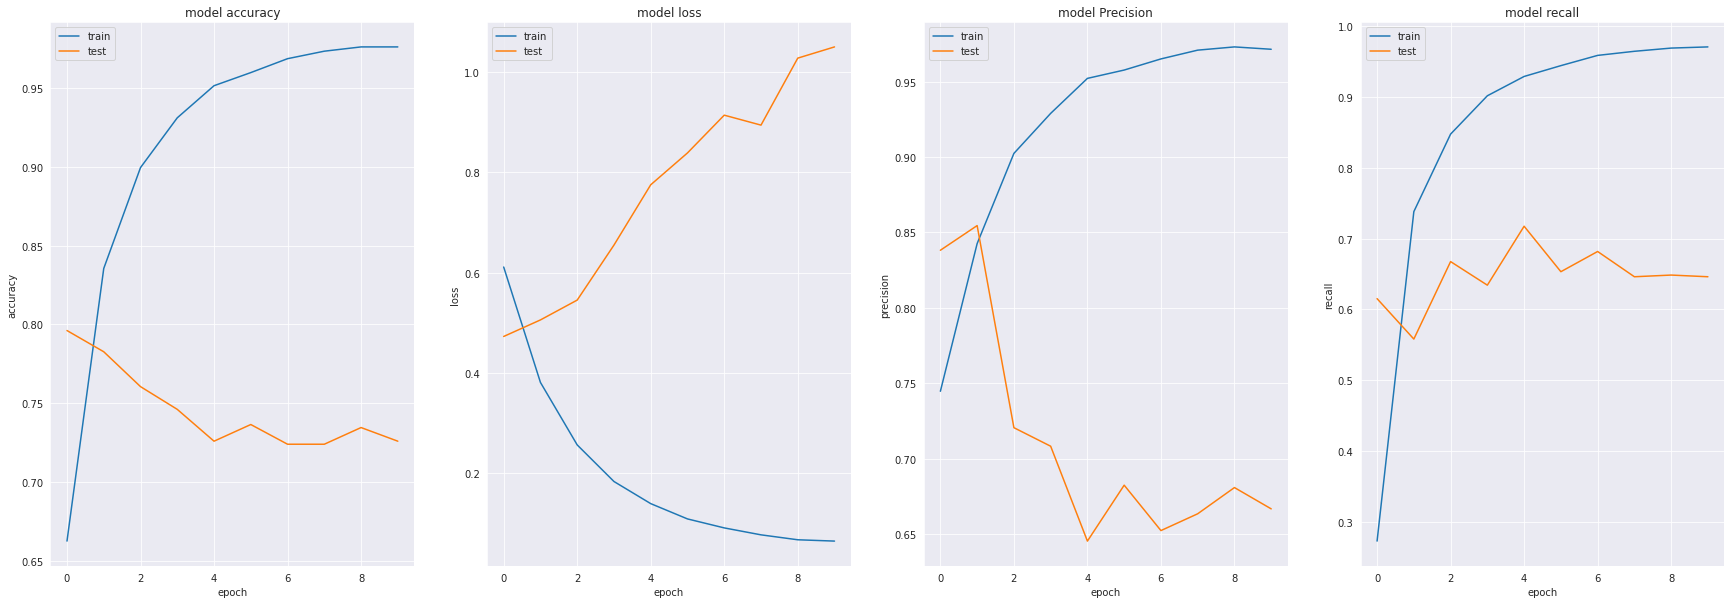

In [45]:
plt.figure(figsize=(30,10))
#Plotting Accuracy
plt.subplot(1,4,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Plotting loss
plt.subplot(1,4,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#Plotting precision
plt.subplot(1,4,3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#Plotting Recall
plt.subplot(1,4,4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



## BERT Model

Our previous model had significant overfitting, even with dropout layers included. Let's try to re-work out data and fine-tune BERT for our embeddings.

In [46]:
!pip install tensorflow_text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 10.0 MB/s 
     |████████████████████████████████| 1.8 MB 8.5 MB/s 
     |████████████████████████████████| 596 kB 66.1 MB/s 
     |████████████████████████████████| 90 kB 12.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 56.9 MB/s 
     |████████████████████████████████| 352 kB 76.6 MB/s 
     |████████████████████████████████| 47.7 MB 110 kB/s 
     |████████████████████████████████| 99 kB 12.3 MB/s 
     |████████████████████████████████| 213 kB 68.4 MB/s 
     |████████████████████████████████| 1.2 MB 65.6 MB/s 


In [53]:
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.callbacks import EarlyStopping

from official.nlp import optimization
from tqdm.notebook import tqdm

In [48]:
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_preprocessor = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(df.text, df.target, test_size=0.10, random_state=1)

batch_size = 32
seed = 42
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(batch_size)

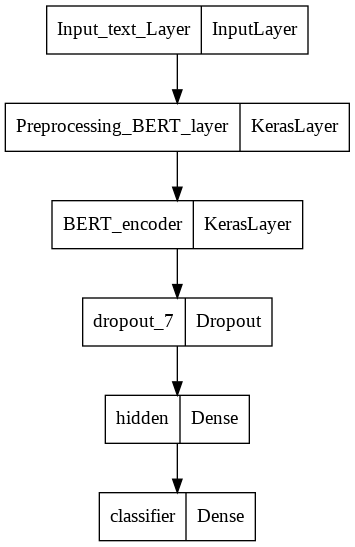

In [85]:
def classifier_model():

    # classifier = Sequential()
    # classifier.add(Input(shape=(), dtype=tf.string))
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Input_text_Layer')

    # classifier.add(hub.KerasLayer(bert_preprocessor))
    preprocessor = hub.KerasLayer(bert_preprocessor, name = 'Preprocessing_BERT_layer')


    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')

    outputs = encoder(encoder_inputs)

    x = outputs["pooled_output"]
    x = tf.keras.layers.Dropout(0.30)(x) #<--- Can adjust the Dropout rate to see impact on performance
    x = tf.keras.layers.Dense(8,activation ="relu",name ="hidden")(x)
    x = tf.keras.layers.Dense(1, activation= "sigmoid" , name='classifier')(x)

    return tf.keras.Model(text_input, x)
classifier_model = classifier_model()

tf.keras.utils.plot_model(classifier_model)

In [86]:
EPOCHS = 2
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5

optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


classifier_model.compile(optimizer=optimizer,
                     loss=LOSS,
                     metrics=METRICS)

es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [87]:
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[es])

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


195/195 [==============================] - 193s 899ms/step - loss: 0.5783 - accuracy: 0.7128 - precision: 0.6423 - recall: 0.6769 - val_loss: 0.4580 - val_accuracy: 0.8055 - val_precision: 0.9012 - val_recall: 0.5678
Epoch 2/2
195/195 [==============================] - 176s 904ms/step - loss: 0.4173 - accuracy: 0.8299 - precision: 0.8479 - recall: 0.7157 - val_loss: 0.4389 - val_accuracy: 0.8156 - val_precision: 0.8311 - val_recall: 0.6667


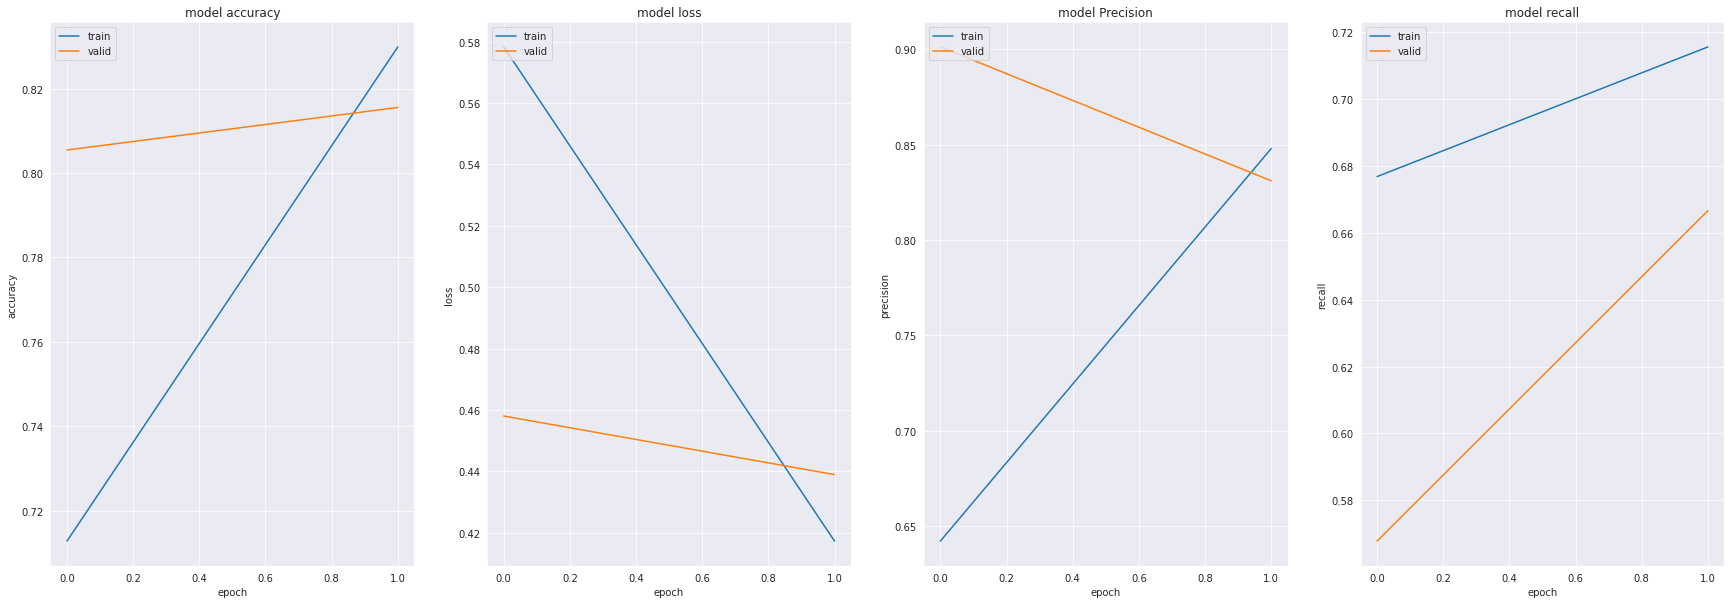

In [88]:
plt.figure(figsize=(30,10))
#Plotting Accuracy
plt.subplot(1,4,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# Plotting loss
plt.subplot(1,4,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

#Plotting precision
plt.subplot(1,4,3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

#Plotting Recall
plt.subplot(1,4,4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')



In [73]:
test_df = pd.read_csv('/content/test.csv')

In [74]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [76]:
probs = classifier_model.predict(test_df["text"]) 
threshold = 0.4
preds = np.where(probs[:,] > threshold, 1, 0)

In [77]:
preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [79]:
submission = pd.read_csv('/content/sample_submission.csv')
submission["target"]=preds

submission.to_csv('submission.csv', index=False, header=True)

In [80]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
